# 3546 Deep Learning - Term Project: Dimensionality reduction of financial time series and applications using a variational autoencoder

# Notebook 2/2: VAE & Index Construction

## April 10, 2019
## By:
* Lagnassa Marie Imokoyende
* Humberto Ribeiro de Souza

This notebook contains:

*   the generation of the simulated data
*  the implementation of the VAE model
*  the creation of the index.

In [1]:
import os
import pandas as pd
import numpy as np
import scipy

from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

import matplotlib.pyplot as plt
import argparse

from numpy.random import seed
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
from keras import losses

Using TensorFlow backend.


In [2]:
#Set this variable in the case you are running local.
# RUN_LOCAL=0 will point to the Google Drive
# RUN_LOCAL=1 assume you are running local or equivalent mounting. 
#   It assumes that the xlsx files are in the same folder

RUN_LOCAL=1
PATH_FILES = '.'

In [3]:
# Use only if needed
if RUN_LOCAL==0:
    from google.colab import drive
    drive.mount('/content/gdrive')

In [4]:
if RUN_LOCAL==0:
    PATH_FILES = '/content/gdrive/My Drive/Datasets/3546 Final Project'
    ## We check the access
    print(os.listdir(PATH_FILES))


# Create the simulated training and test sets

The geometric moving average dataset only contains data for 423 stocks. We will use stochastic simulation to augment the dataset.

The goal is not to model exactly the behavior of the geometric moving average time series of a given stock. We want the model to be trained on time series that are similar to a typical geometric moving average curve but without learning the specificities of the reference stock market dataset.

We will first load the geometric moving average created in notebook 1 (*3546 Deep Learning Project - Data Treatment.ipynb*) and then divide the dataset in two time periods of equal length.

## Import the geometric moving average dataset

In [5]:
geoMA_5d_stocks = pd.read_excel(PATH_FILES + '/geoMA_5d_stocks.xlsx')
geoMA_5d_stocks.dropna(inplace = True)
geoMA_5d_stocks_T = geoMA_5d_stocks.T

In [6]:
geoMA_5d_stocks.head()

,ABBD,HGBD,CAFC,DABC,HBCF,EGBD,GHFE,ACFF,DEBG,FAAF,...,CGEG,DFDC,CFHE,GAFE,CEGB,BBBF,FBFA,BAAD,DBHC,CGBB
2016-01-12,0.992338,0.988821,0.989424,0.997762,0.986470,0.984129,0.998091,0.989600,0.993235,0.977558,...,0.998239,0.990540,1.000000,0.997283,1.012098,0.995122,1.002404,0.969215,1.00000,1.0
2016-01-13,0.996175,0.992179,0.989424,1.000000,0.993441,0.984129,0.995368,0.992397,0.995936,0.983125,...,1.000000,0.998687,1.000000,0.994871,1.006491,0.986229,1.000000,1.000000,1.00000,1.0
2016-01-14,0.992404,0.993299,0.986959,0.992476,0.989088,0.981743,0.995041,0.992397,0.993604,0.981993,...,1.009148,1.000872,0.982598,0.985433,1.002618,0.984764,0.992735,1.000000,1.00000,1.0
2016-01-15,1.002007,1.005394,0.986959,0.996006,0.996686,0.991347,0.996768,1.004218,1.000705,0.982737,...,1.013850,1.016067,0.981118,0.983524,0.994219,0.965292,0.995074,0.954877,0.95483,1.0
2016-01-18,0.994636,0.997212,0.985798,0.996006,0.996686,0.989739,0.995659,1.004676,0.994490,0.986638,...,0.999386,1.013834,0.977525,0.981752,0.985247,0.966094,0.984744,0.954877,0.95483,1.0


We transpose the dataset to have one stock per line.

In [7]:
geoMA_5d_stocks_T.head()

,2016-01-12 00:00:00,2016-01-13 00:00:00,2016-01-14 00:00:00,2016-01-15 00:00:00,2016-01-18 00:00:00,2016-01-19 00:00:00,2016-01-20 00:00:00,2016-01-21 00:00:00,2016-01-22 00:00:00,2016-01-26 00:00:00,...,2019-02-15 00:00:00,2019-02-19 00:00:00,2019-02-20 00:00:00,2019-02-21 00:00:00,2019-02-22 00:00:00,2019-02-25 00:00:00,2019-02-26 00:00:00,2019-02-27 00:00:00,2019-02-28 00:00:00,2019-03-01 00:00:00
ABBD,0.992338,0.996175,0.992404,1.002007,0.994636,0.996557,0.993036,0.995753,0.999325,1.008587,...,1.005679,1.006413,1.003681,1.003549,1.004117,1.005864,1.007282,1.009354,1.008312,1.005137
HGBD,0.988821,0.992179,0.993299,1.005394,0.997212,0.996710,0.994502,0.995945,1.001632,1.009282,...,1.000568,0.996890,0.999371,1.003462,0.999844,1.002008,1.008411,1.005487,1.002788,1.003042
CAFC,0.989424,0.989424,0.986959,0.986959,0.985798,0.989711,0.989711,0.992182,1.001060,1.008947,...,1.004808,1.000743,1.003657,1.003657,0.996627,0.998635,1.003489,1.000655,1.000655,1.000000
DABC,0.997762,1.000000,0.992476,0.996006,0.996006,0.996006,0.995882,1.003431,0.999876,0.999876,...,1.000414,1.000629,1.000630,1.000630,0.998195,0.998884,0.998965,0.997960,0.997960,0.997639
HBCF,0.986470,0.993441,0.989088,0.996686,0.996686,1.000857,0.991468,0.992309,1.003376,1.003376,...,0.996091,0.989444,0.995508,0.997061,0.992744,0.993557,1.005934,1.007272,1.006421,1.008839


### Divide in two time periods

In [8]:
len(geoMA_5d_stocks)/2

388.0

In [9]:
geoMA_5d_stocks_p1 = geoMA_5d_stocks.head(int(len(geoMA_5d_stocks)/2))
geoMA_5d_stocks_p2 = geoMA_5d_stocks.tail(int(len(geoMA_5d_stocks)/2))

In [10]:
print('len(geoMA_5d_stocks_p1) =', len(geoMA_5d_stocks_p1))
print('len(geoMA_5d_stocks_p2) =', len(geoMA_5d_stocks_p2))

len(geoMA_5d_stocks_p1) = 388
len(geoMA_5d_stocks_p2) = 388


#### Verification

In [11]:
geoMA_5d_stocks_p1.tail()

,ABBD,HGBD,CAFC,DABC,HBCF,EGBD,GHFE,ACFF,DEBG,FAAF,...,CGEG,DFDC,CFHE,GAFE,CEGB,BBBF,FBFA,BAAD,DBHC,CGBB
2017-07-31,0.998172,0.998562,1.002159,1.000000,1.003872,1.001689,0.993497,0.997808,1.001285,1.002584,...,0.998951,1.005164,0.998917,0.999300,1.000440,1.019369,1.019245,1.002841,0.983524,1.0
2017-08-01,0.996823,0.993613,0.997673,1.003090,1.002733,0.998679,0.996245,0.999049,0.999669,0.999894,...,1.000707,1.000339,0.996753,1.000000,1.003960,0.988092,1.015057,1.004982,0.999846,1.0
2017-08-02,0.993745,0.994855,0.988318,1.001590,1.002438,0.996904,0.998682,0.999049,0.999192,0.994799,...,0.997836,0.993220,0.995614,0.998804,1.006727,0.986629,1.011829,1.001699,0.996020,1.0
2017-08-03,0.993626,1.004711,0.988512,1.004182,1.001161,0.999502,1.001007,0.998863,0.999523,1.001984,...,0.995700,1.001718,0.994505,0.999100,0.999564,0.992664,1.013437,1.000000,0.996323,1.0
2017-08-04,0.994796,1.004196,0.986593,1.004182,1.002233,0.999158,1.000465,0.996571,0.999854,0.998132,...,0.991149,1.000338,0.994505,1.001957,0.996918,0.993710,1.012117,1.013800,1.018670,1.0


In [12]:
geoMA_5d_stocks_p2.head()

,ABBD,HGBD,CAFC,DABC,HBCF,EGBD,GHFE,ACFF,DEBG,FAAF,...,CGEG,DFDC,CFHE,GAFE,CEGB,BBBF,FBFA,BAAD,DBHC,CGBB
2017-08-07,0.997970,1.008191,0.990939,1.004182,1.001853,1.004277,1.000722,1.001180,0.999854,1.007294,...,0.991433,1.013848,0.994505,1.003346,0.999119,0.990048,1.005814,1.031725,1.040652,1.0
2017-08-08,0.998793,1.012777,0.990750,1.001812,1.002667,1.003673,1.000807,0.999363,1.000845,1.005171,...,0.995372,1.022677,1.007536,1.004865,1.002165,0.992480,1.005277,1.031352,1.037563,1.0
2017-08-09,1.000413,1.012916,0.999225,1.001952,1.003530,1.004440,0.998746,0.999204,1.001324,1.004739,...,1.005031,1.036058,1.008735,1.003992,1.004789,0.998731,1.001852,1.032346,1.038579,1.0
2017-08-10,1.002057,1.005593,0.999121,0.999366,1.004809,1.004760,1.002279,1.000980,1.000992,1.002299,...,1.003246,1.028117,1.003330,1.002999,1.009007,1.002488,1.002360,1.034426,1.038579,1.0
2017-08-11,1.002968,1.003180,0.999902,1.003198,1.000718,1.003039,1.003869,0.999936,1.000992,1.003573,...,1.003610,1.026242,1.002225,0.999722,1.014674,0.997423,1.006664,1.012662,1.011735,1.0


### Transpose the dataset

We transpose the dataset of the 1st period to have one stock per row (instead of columns).

In [13]:
geoMA_5d_stocks_p1_T = geoMA_5d_stocks_p1.T

## Create synthetic time series using stochastic simulation

The modeling of the geometric moving average time series will be done using geometric brownian motion ***S(t)*** defined by:
$$ \large S(t) = S_0\exp^{X(t)} $$
where: $$ X_t = logreturns(t) = ln(S_{t}\div S_{t-1})$$



For each stock, ***logreturns(t)*** is randomly selected following the following steps:

1.   Calculate a vector of log returns over the two time periods (using ***geoMA_5d_stocks_T***)
2.   Randomly select one log returns from the existing vector calculated in step 1

1.   Construct a generated path using: $ S_t = S_0\exp{logreturns(t)}$ $\forall$ $t>=1$










We will randomly select 100 stocks and generate 100 simulated paths for each stock. This will allow us to obtain 10,000 geometric moving average series.

For more on the geometric brownian motion process, see: http://www.columbia.edu/~ks20/FE-Notes/4700-07-Notes-GBM.pdf.

In [14]:
n_simpath_per_ticker = 100
n_tickers_selected = 100 # We will select 100 random tickers without replacement from the NYSE dataframe
random_tickers_selected = np.random.choice(len(geoMA_5d_stocks_p1_T), n_tickers_selected)
n_rows_sim_paths_matrix = n_tickers_selected * n_simpath_per_ticker
sim_paths_matrix  = np.zeros((n_rows_sim_paths_matrix, len(geoMA_5d_stocks_p1_T.iloc[0])))
for i in range(len(random_tickers_selected)):
#for i in range(2):
  random_index = random_tickers_selected[i]
  #print(random_index)
  rd_stock_logReturns = np.diff(np.log(geoMA_5d_stocks_T.iloc[random_index]))
  for j in range(n_simpath_per_ticker):
    sim_path = np.zeros(len(geoMA_5d_stocks_p1_T.iloc[random_index]))
    sim_path[0] = geoMA_5d_stocks_p1_T.iloc[random_index][0]
    for k in range(1,len(sim_path)):
      sim_path[k] = sim_path[0]*np.exp(rd_stock_logReturns[np.random.randint(0, len(rd_stock_logReturns))])
    sim_paths_matrix[i*100+j] = sim_path

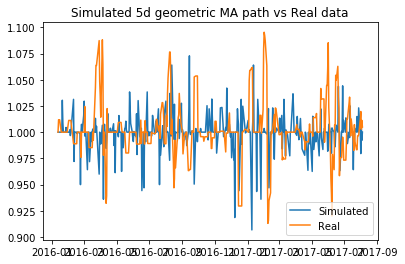

In [15]:
# Let's plot a generated sample against a real geometric time series curve
fig, ax = plt.subplots()
ax.plot(geoMA_5d_stocks_p1_T.columns, sim_paths_matrix[0], label = 'Simulated')
ax.plot(geoMA_5d_stocks_p1_T.columns, geoMA_5d_stocks_p1_T.iloc[random_tickers_selected[0]], label = 'Real')
ax.set_title('Simulated 5d geometric MA path vs Real data')
Legend = ax.legend(loc='lower right')

In [16]:
# We shuffle the generated curves
shuffled_array = np.random.permutation(sim_paths_matrix)

We have expanded a dataset of 423 time series to 10,000 new time series similar (but not equal) to the stock dataset.
This will allow us to keep the actual stock dataset universe for predictions and not even have to use it for the validation.

## Create a training and test dataset

The training set will be 80% of the simulated paths.

In [17]:
# We split the simulated time series into a training and test set
x_train = shuffled_array[0:8000]
x_test = shuffled_array[8000:]

In [18]:
print(x_train.shape)
print(x_test.shape)

(8000, 388)
(2000, 388)


# Variational Autoencoder Model

We will use a simple VAE architecture similar to the one described in the [Keras blog](https://github.com/keras-team/keras/blob/master/examples/variational_autoencoder.py).

Our main goal is to reduce the dimensions of a time series vector with 388 elements to a two dimensional point.

As described in the Keras tutorial, we first setup the network parameters:

In [19]:
# network parameters
original_dim = x_train.shape[1]
input_shape = (original_dim, )
intermediate_dim = 300
batch_size = 128
latent_dim = 2
epochs = 10

Then we map inputs to the latent distribution parameters:

In [20]:
# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

We then use those parameters to sample new points from the latent space:

In [21]:
# reparameterization trick
# instead of sampling from Q(z|X), sample epsilon = N(0,I)
# z = z_mean + sqrt(var) * epsilon
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [22]:
# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

We instantiate the encoder model:

In [23]:
encoder = Model(inputs, z_mean)
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 388)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 300)               116700    
_________________________________________________________________
z_mean (Dense)               (None, 2)                 602       
Total params: 117,302
Trainable params: 117,302
Non-trainable params: 0
_________________________________________________________________


We build the decoder model:

In [24]:
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

We instantiate the decoder model:

In [25]:
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 2)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 300)               900       
_________________________________________________________________
dense_3 (Dense)              (None, 388)               116788    
Total params: 117,688
Trainable params: 117,688
Non-trainable params: 0
_________________________________________________________________


We instantiate the VAE model:

In [26]:
outputs = decoder(encoder(inputs))
vae = Model(inputs, outputs, name='vae_mlp')

As in the Keras tutorial, we define a custom loss function:

In [27]:
def vae_loss(x, x_decoded_mean):
    xent_loss = losses.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return xent_loss + kl_loss

We compile the model:

In [28]:
vae.compile(optimizer='rmsprop', loss=vae_loss)

## Train the model

In [29]:
results = vae.fit(x_train, x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

Train on 8000 samples, validate on 2000 samples
Epoch 1/10
8000/8000 [==============================] - 2s 221us/step - loss: 1.0052 - val_loss: 0.7400
Epoch 2/10
8000/8000 [==============================] - 1s 137us/step - loss: 0.4440 - val_loss: 0.2684
Epoch 3/10
8000/8000 [==============================] - 1s 136us/step - loss: 0.2165 - val_loss: 0.2174
Epoch 4/10
8000/8000 [==============================] - 1s 151us/step - loss: 0.1677 - val_loss: 0.0831
Epoch 5/10
8000/8000 [==============================] - 1s 145us/step - loss: 0.1156 - val_loss: 0.1334
Epoch 6/10
8000/8000 [==============================] - 1s 152us/step - loss: 0.0963 - val_loss: 0.0655
Epoch 7/10
8000/8000 [==============================] - 1s 144us/step - loss: 0.0714 - val_loss: 0.1386
Epoch 8/10
8000/8000 [==============================] - 1s 136us/step - loss: 0.0627 - val_loss: 0.0691
Epoch 9/10
8000/8000 [==============================] - 1s 133us/step - loss: 0.0617 - val_loss: 0.0720
Epoch 10/10
8000

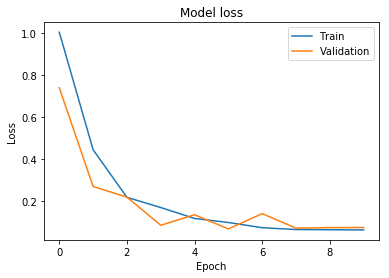

In [30]:
# Plot training & validation loss values
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

## Get predictions

### Futures dataset

#### Load the data

In [31]:
geoMA_5d_futures = pd.read_excel(PATH_FILES + '/geoMA_5d_futures.xlsx', index_col = 0)

In [32]:
geoMA_5d_futures.head()

,Settle
Date,
2016-01-12,0.993060
2016-01-13,0.991061
2016-01-14,0.992256
2016-01-15,0.997690
2016-01-18,0.995562


In [33]:
#Rename column "Settle" to "Futures"
geoMA_5d_futures.rename(columns={"Settle": "Futures"}, inplace = True)

In [34]:
# We verify
geoMA_5d_futures.columns

Index(['Futures'], dtype='object')

#### Then divide the futures dataset into two periods as well

In [35]:
geoMA_5d_futures_p1 = geoMA_5d_futures.head(int(len(geoMA_5d_futures)/2))
geoMA_5d_futures_p2 = geoMA_5d_futures.tail(int(len(geoMA_5d_futures)/2))
print('len(geoMA_5d_futures_p1) =', len(geoMA_5d_futures_p1))
print('len(geoMA_5d_futures_p2) =', len(geoMA_5d_futures_p1))

len(geoMA_5d_futures_p1) = 388
len(geoMA_5d_futures_p2) = 388


In [36]:
geoMA_5d_futures_p1.tail()

,Futures
Date,
2017-07-31,1.006975
2017-08-01,1.006605
2017-08-02,1.000779
2017-08-03,1.000067
2017-08-04,0.999748


In [37]:
geoMA_5d_futures_p2.head()

,Futures
Date,
2017-08-07,1.000353
2017-08-08,1.002803
2017-08-09,1.007374
2017-08-10,1.006390
2017-08-11,1.007360


### Create the matrices to test (for period 1)

In [38]:
dataframe_to_test_p1 = geoMA_5d_stocks_p1.join(geoMA_5d_futures_p1)

In [39]:
dataframe_to_test_p1.tail()

,ABBD,HGBD,CAFC,DABC,HBCF,EGBD,GHFE,ACFF,DEBG,FAAF,...,DFDC,CFHE,GAFE,CEGB,BBBF,FBFA,BAAD,DBHC,CGBB,Futures
2017-07-31,0.998172,0.998562,1.002159,1.000000,1.003872,1.001689,0.993497,0.997808,1.001285,1.002584,...,1.005164,0.998917,0.999300,1.000440,1.019369,1.019245,1.002841,0.983524,1.0,1.006975
2017-08-01,0.996823,0.993613,0.997673,1.003090,1.002733,0.998679,0.996245,0.999049,0.999669,0.999894,...,1.000339,0.996753,1.000000,1.003960,0.988092,1.015057,1.004982,0.999846,1.0,1.006605
2017-08-02,0.993745,0.994855,0.988318,1.001590,1.002438,0.996904,0.998682,0.999049,0.999192,0.994799,...,0.993220,0.995614,0.998804,1.006727,0.986629,1.011829,1.001699,0.996020,1.0,1.000779
2017-08-03,0.993626,1.004711,0.988512,1.004182,1.001161,0.999502,1.001007,0.998863,0.999523,1.001984,...,1.001718,0.994505,0.999100,0.999564,0.992664,1.013437,1.000000,0.996323,1.0,1.000067
2017-08-04,0.994796,1.004196,0.986593,1.004182,1.002233,0.999158,1.000465,0.996571,0.999854,0.998132,...,1.000338,0.994505,1.001957,0.996918,0.993710,1.012117,1.013800,1.018670,1.0,0.999748


In [40]:
matrix_to_test_p1 = dataframe_to_test_p1.T.values

### Obtain the predictions (for period 1)

In [41]:
encoded_p1 = encoder.predict(matrix_to_test_p1, batch_size=batch_size)

# Convert the predictions into a dataframe
encoded_p1_df = pd.DataFrame(data = encoded_p1, columns = ['x','y'], index = dataframe_to_test_p1.T.index)

In [42]:
encoded_p1_df.tail()

,x,y
FBFA,0.039404,-0.018855
BAAD,0.041755,-0.026624
DBHC,0.042601,-0.025670
CGBB,0.040644,-0.017977
Futures,0.043204,-0.018102


#### Calculate the distances between the futures contract point and all other points in the stocks dataset

In [43]:
ref_point = encoded_p1_df.loc['Futures'].values
encoded_p1_df['Distance'] = scipy.spatial.distance.cdist([ref_point], encoded_p1_df, metric='euclidean')[0]

#### Get the 50 closest points to the Futures point

In [44]:
closest_points = encoded_p1_df.sort_values('Distance', ascending = True)
closest_points_top50 = closest_points.head(51)[1:] #We take head(51), because the Futures reference point is the first entry
closest_points_top50['Ticker'] = closest_points_top50.index

In [45]:
closest_points_top50.head()

,x,y,Distance,Ticker
FBCE,0.043366,-0.018374,0.000316,FBCE
CFCH,0.042835,-0.018229,0.000391,CFCH
ABBD,0.042764,-0.017987,0.000455,ABBD
CAHB,0.043378,-0.017658,0.000477,CAHB
CCHD,0.042713,-0.018076,0.000491,CCHD


#### Plot the results

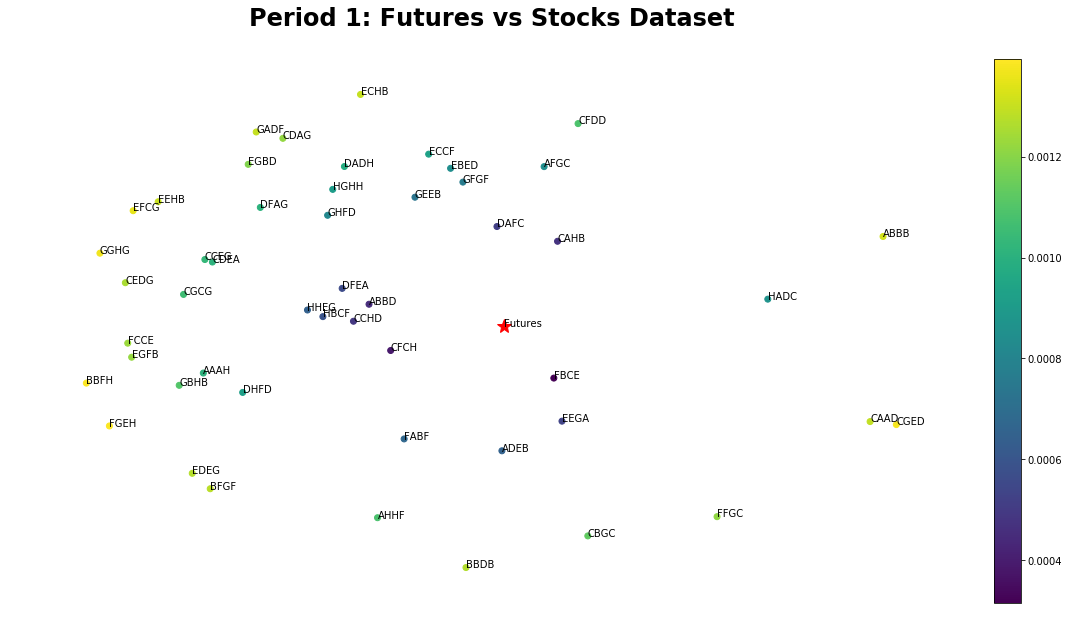

In [46]:
x_i = closest_points_top50['x']*1000
y_i = closest_points_top50['y']*100
d_i = closest_points_top50['Distance']
ticker_i = closest_points_top50['Ticker']
fig, ax = plt.subplots(figsize=(20, 10))
im = ax.scatter(x_i, y_i, c = d_i, cmap = 'viridis')
plt.plot(ref_point[0]*1000, ref_point[1]*100,'r*', markersize = 15)
ax.annotate('Futures',(ref_point[0]*1000, ref_point[1]*100))
plt.colorbar(im, ax=ax)
plt.axis('off')
ax.set_title('Period 1: Futures vs Stocks Dataset\n', fontsize = 24, fontweight='bold')
for i, txt in enumerate(ticker_i):
    ax.annotate(txt, (x_i[i], y_i[i]))

# Application: Index construction

We will use the process described above to create an index.
Due to the randomness of the VAE model, we will not obtain the same exact list of top 50 stocks on each run.

To make sure that we get a fair representation of the closest 50 points, we will run the VAE model 10 times (re-initializing and retraining it on each run). Then we will take the 50 closest points found on each run to create a dataframe ***closest_points_df*** dataframe of length 500. 

In [47]:
from datetime import date

## Build the *closest_points_df* dataframe

In [48]:
today = date.today()
today_string = str(today.year)+str(today.month)+str(today.day)
n_trials = 10
path = PATH_FILES + '/Trial_outputs/' #The path should exist prior to execution.

# network parameters
original_dim = x_train.shape[1]
input_shape = (original_dim, )
intermediate_dim = 300
batch_size = 128
latent_dim = 2
epochs = 10

for i in range(n_trials): # Create the VAE model and get the predictions n_trials(=10) times.
  n_rows_sim_paths_matrix = n_tickers_selected * n_simpath_per_ticker
  sim_paths_matrix  = np.zeros((n_rows_sim_paths_matrix, len(geoMA_5d_stocks_p1_T.iloc[0])))
  for j in range(len(random_tickers_selected)):
    random_index = random_tickers_selected[j]
    rd_stock_logReturns = np.diff(np.log(geoMA_5d_stocks_T.iloc[random_index]))
    for k in range(n_simpath_per_ticker):
      sim_path = np.zeros(len(geoMA_5d_stocks_p1_T.iloc[random_index]))
      sim_path[0] = geoMA_5d_stocks_p1_T.iloc[random_index][0]
      for l in range(1,len(sim_path)):
        sim_path[l] = sim_path[0]*np.exp(rd_stock_logReturns[np.random.randint(0, len(rd_stock_logReturns))])
      sim_paths_matrix[j*100+k] = sim_path
   
  shuffled_array = np.random.permutation(sim_paths_matrix)
  
  x_train = shuffled_array[0:8000]
  x_test = shuffled_array[8000:]

  # VAE model = encoder + decoder
  # build encoder model
  inputs = Input(shape=input_shape, name='encoder_input')
  x = Dense(intermediate_dim, activation='relu')(inputs)
  z_mean = Dense(latent_dim, name='z_mean')(x)
  z_log_var = Dense(latent_dim, name='z_log_var')(x)
  
  # use reparameterization trick to push the sampling out as input
  # note that "output_shape" isn't necessary with the TensorFlow backend
  z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
  
  # instantiate encoder model
  encoder = Model(inputs, z_mean)
  # build decoder model
  latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
  x = Dense(intermediate_dim, activation='relu')(latent_inputs)
  outputs = Dense(original_dim, activation='sigmoid')(x)
  # instantiate decoder model
  decoder = Model(latent_inputs, outputs, name='decoder')
  # instantiate VAE model
  outputs = decoder(encoder(inputs))
  vae = Model(inputs, outputs, name='vae_mlp')

  vae.compile(optimizer='rmsprop', loss=vae_loss)

  results = vae.fit(x_train, x_train,
          shuffle=True,
          epochs=epochs,
          batch_size=batch_size,
          validation_data=(x_test, x_test))

  encoded_p1 = encoder.predict(matrix_to_test_p1, batch_size=batch_size)
  # Convert the predictions into a dataframe
  encoded_p1_df = pd.DataFrame(data = encoded_p1, columns = ['x','y'], index = dataframe_to_test_p1.T.index)


  ref_point = encoded_p1_df.loc['Futures'].values
  encoded_p1_df['Distance'] = scipy.spatial.distance.cdist([ref_point], encoded_p1_df, metric='euclidean')[0]
  closest_points = encoded_p1_df.sort_values('Distance', ascending = True)
  closest_points_top50 = closest_points.head(51)[1:] #We take head(51), because the Futures reference point is the first entry
  closest_points_top50['Ticker'] = closest_points_top50.index
  
  # Save the top 50 closest points obtained for the cuurent run in a .xlsx file
  loop_currentfilename = path + 'Futures_vs_stocks_period1_'+today_string+'_trial_'+str(i+1)+'.xlsx'
  closest_points_top50.to_excel(loop_currentfilename)

Train on 8000 samples, validate on 2000 samples
Epoch 1/10
8000/8000 [==============================] - 1s 129us/step - loss: 1.0362 - val_loss: 0.3931
Epoch 2/10
8000/8000 [==============================] - 1s 128us/step - loss: 0.3290 - val_loss: 0.2218
Epoch 3/10
8000/8000 [==============================] - 1s 128us/step - loss: 0.1739 - val_loss: 0.0651
Epoch 4/10
8000/8000 [==============================] - 1s 135us/step - loss: 0.1280 - val_loss: 0.1355
Epoch 5/10
8000/8000 [==============================] - 1s 130us/step - loss: 0.0996 - val_loss: 0.1018
Epoch 6/10
8000/8000 [==============================] - 1s 127us/step - loss: 0.0760 - val_loss: 0.0619
Epoch 7/10
8000/8000 [==============================] - 1s 127us/step - loss: 0.0620 - val_loss: 0.0766
Epoch 8/10
8000/8000 [==============================] - 1s 127us/step - loss: 0.0564 - val_loss: 0.0621
Epoch 9/10
8000/8000 [==============================] - 1s 123us/step - loss: 0.0554 - val_loss: 0.0481
Epoch 10/10
8000

8000/8000 [==============================] - 1s 133us/step - loss: 0.1100 - val_loss: 0.0890
Epoch 7/10
8000/8000 [==============================] - 1s 131us/step - loss: 0.0940 - val_loss: 0.0638
Epoch 8/10
8000/8000 [==============================] - 1s 127us/step - loss: 0.0886 - val_loss: 0.1039
Epoch 9/10
8000/8000 [==============================] - 1s 124us/step - loss: 0.0840 - val_loss: 0.0697
Epoch 10/10
8000/8000 [==============================] - 1s 127us/step - loss: 0.0823 - val_loss: 0.0853
Train on 8000 samples, validate on 2000 samples
Epoch 1/10
8000/8000 [==============================] - 2s 279us/step - loss: 11.0050 - val_loss: 0.2360
Epoch 2/10
8000/8000 [==============================] - 1s 149us/step - loss: 0.2865 - val_loss: 0.3969
Epoch 3/10
8000/8000 [==============================] - 1s 139us/step - loss: 0.3149 - val_loss: 0.2508
Epoch 4/10
8000/8000 [==============================] - 1s 138us/step - loss: 0.2346 - val_loss: 0.1985
Epoch 5/10
8000/8000 [===

### Build the dataframe using the excel files saved

In [49]:
results = os.listdir(PATH_FILES + '/Trial_outputs/')
results_df = pd.DataFrame()
for f in results:
  path = PATH_FILES + '/Trial_outputs/'+str(f)
  data = pd.read_excel(path)
  results_df = results_df.append(data)

In [50]:
results_df.head()

,x,y,Distance,Ticker
FABF,-0.025866,0.074853,0.000006,FABF
AHAE,-0.025992,0.074828,0.000123,AHAE
EAEE,-0.025972,0.074977,0.000160,EAEE
HHEG,-0.026045,0.074922,0.000186,HHEG
EFGB,-0.025724,0.074728,0.000193,EFGB


We sort all the points by distance (in ascending order)

In [51]:
sorted_by_dist = results_df.sort_values('Distance', ascending = True)

In [52]:
# We verify:
sorted_by_dist.head()

,x,y,Distance,Ticker
FABF,-0.025866,0.074853,0.000006,FABF
EAAF,0.080422,-0.011364,0.000029,EAAF
EEHB,0.063133,-0.023954,0.000076,EEHB
AHAE,-0.025992,0.074828,0.000123,AHAE
BGFB,-0.036067,0.151240,0.000139,BGFB


In [53]:
len(sorted_by_dist)

500

We drop the duplicate tickers, keeping only the first occurance.

In [54]:
sorted_by_dist.drop_duplicates(subset='Ticker', keep='first', inplace = True)

In [55]:
len(sorted_by_dist)

260

## Compute the weights of each stock

We calculate the weight of each stock such that the points closest to the futures contract point will get a higher weight than the ones further from it.

With non anonymized stock data, it is important to filter the results obtained to keep the market capitalization range we want and to also remove outliers (stocks that are not related to the futures contract)  before computing the index weights.

In [56]:
# Calculate the weights
top50 = sorted_by_dist.head(50)
top50['Weight'] = (1/top50['Distance'])/np.sum(1/top50['Distance'])

d:\uoft-work\handson-ml\env\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [57]:
top50.head()

,x,y,Distance,Ticker,Weight
FABF,-0.025866,0.074853,0.000006,FABF,0.396408
EAAF,0.080422,-0.011364,0.000029,EAAF,0.084758
EEHB,0.063133,-0.023954,0.000076,EEHB,0.032279
AHAE,-0.025992,0.074828,0.000123,AHAE,0.019997
BGFB,-0.036067,0.151240,0.000139,BGFB,0.017639


## Determine the number of shares of each ticker

### Load the stock data

In [58]:
stock_data = pd.read_excel(PATH_FILES + '/stocks_data.xlsx')

# Remove the weekend and holidays
# We will use a well known stock (anonymized ticker: 'EAGH') as our reference data to detect weekends and public holidays
stock_data = stock_data[pd.notnull(stock_data['EAGH'])]

#After removing weekend and holidays, we clean the data further by removing columns which still contains NaN values
#Drop tickers for which there are NaN values
stock_data.dropna(axis='columns', inplace = True)

# We further drop all rows with 0
stock_data = stock_data[(stock_data != 0)]

#Get the stock prices for the top 50 stocks we selected
stock_data_top50 = stock_data[top50['Ticker']]

In [59]:
#Get the stock prices on January 4th 2016

jan4_2016_stockPrice = np.zeros(len(stock_data_top50.columns))
for i in range(len(jan4_2016_stockPrice)):
  if stock_data_top50.columns[i] == top50['Ticker'].iloc[i]:
    jan4_2016_stockPrice[i] = stock_data_top50[stock_data_top50.columns[i]].iloc[0]

In [60]:
top50['Price Jan4_2016'] = jan4_2016_stockPrice

d:\uoft-work\handson-ml\env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [61]:
top50.head()

,x,y,Distance,Ticker,Weight,Price Jan4_2016
FABF,-0.025866,0.074853,0.000006,FABF,0.396408,14.27
EAAF,0.080422,-0.011364,0.000029,EAAF,0.084758,1.15
EEHB,0.063133,-0.023954,0.000076,EEHB,0.032279,222.40
AHAE,-0.025992,0.074828,0.000123,AHAE,0.019997,111.11
BGFB,-0.036067,0.151240,0.000139,BGFB,0.017639,167.58


### Compute the number of shares

In [62]:
net_assets = 10000000 # We chose net assets = 10 million (in the currency of the stock market)

numShares = np.zeros(len(stock_data_top50.columns))
for i in range(len(jan4_2016_stockPrice)):
  if stock_data_top50.columns[i] == top50['Ticker'].iloc[i]:
    numShares[i] = int(net_assets*top50['Weight'].iloc[i]/top50['Price Jan4_2016'].iloc[i])
    
top50['numShares'] = numShares

d:\uoft-work\handson-ml\env\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [63]:
top50.head()

,x,y,Distance,Ticker,Weight,Price Jan4_2016,numShares
FABF,-0.025866,0.074853,0.000006,FABF,0.396408,14.27,277791.0
EAAF,0.080422,-0.011364,0.000029,EAAF,0.084758,1.15,737024.0
EEHB,0.063133,-0.023954,0.000076,EEHB,0.032279,222.40,1451.0
AHAE,-0.025992,0.074828,0.000123,AHAE,0.019997,111.11,1799.0
BGFB,-0.036067,0.151240,0.000139,BGFB,0.017639,167.58,1052.0


## Construct the index

To construct the index, we will use the Laspeyres index method which is described in the S&P Dow Jones Indices [Index Mathematics Methodology](https://us.spindices.com/documents/methodologies/methodology-index-math.pdf ).

In [64]:
stock_index = np.zeros(len(stock_data_top50))

for i in range(len(Laspeyres)):
  sum_num = 0
  sum_denom = 0
  for j in range(len(stock_data_top50.columns)):
    sum_num = sum_num + stock_data_top50[stock_data_top50.columns[j]].iloc[i]*top50['numShares'].iloc[j]
    sum_denom = sum_denom + stock_data_top50[stock_data_top50.columns[j]].iloc[0]*top50['numShares'].iloc[j]
  stock_index[i] = sum_num /sum_denom

NameError: name 'Laspeyres' is not defined

In [ ]:
stock_index_df = pd.DataFrame(stock_index*100, columns =  ['stock_index'], index = stock_data_top50.index)

We arbitrarily start the index at 100.

In [ ]:
stock_index_df.plot(figsize=(15,8))

## Let's compare our index with the futures contract time series

### Get the futures data

In [ ]:
futures_data = pd.read_excel(PATH_FILES + '/futures_data_frontMonth.xlsx', index_col = 0)
futures_data.index = pd.to_datetime(futures_data.index) #Convert the index to a datetime index
futures_data.sort_index(inplace = True)

# Only keep values that are also in stock_data dataframe and drop NaN values
futures_data_stock_data = futures_data.loc[futures_data.index.isin(stock_data.index)].dropna()
# We further drop all rows with 0
futures_data = futures_data_stock_data[(futures_data_stock_data != 0)]

In [ ]:
#Then, we update the myIndex dataframe to make it have the same index as in the "Commodities" dataframe created above
stock_index_df = stock_index_df[stock_index_df.index.isin(futures_data.index)]

In [ ]:
futures_data_stock_data_pct_change = futures_data_stock_data.pct_change()
futures_data_stock_data_pct_change.dropna(inplace = True)

In [ ]:
futures_data_stock_data_pct_change.head()

### Scale the time series to the index such that futures_theoretical[0] = stock_index[0] = 100

In [ ]:
futures_theoretical = np.zeros(len(stock_index_df))
futures_theoretical[0] = stock_index_df.iloc[0]
for i in range(len(futures_theoretical)-1):
  futures_theoretical[i+1] = (1+futures_data_stock_data_pct_change.iloc[i])*futures_theoretical[i]

In [ ]:
stock_index_df['Futures'] = futures_theoretical

In [ ]:
stock_index_df.head()

### Plot the Futures index and the stock_index we created

In [ ]:
stock_index_df.plot(figsize=(15,8))

# Conclusion

Our index has mostly the same trend as the reference futures data except for the second half of 2018. Because we use anonymized data, we did not filter the stocks for outliers and market capitalization limits. Furthermore there was no re-balancing throughout the two time periods observed and we ignored distributions.


We believe that the use of variational autoencoders to construct an index can speed up the development of new indices in a stock market for which analysts may not be familiar with. Furthermore, it could help create even more niche indices to be used by ETFs or even new creative investment possibilities for direct indexing firms worldwide.